<a href="https://colab.research.google.com/github/DarwinFer/ProblemainversoKdV1D/blob/main/ProblemainversoKdV1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problema inverso asociado a la ecuación KdV
Se presenta la solución a un problema inverso asociado a la ecuación KdV en 1D.
Primero se realiza la simulación del problema directo para luego generar datos ruidosos y entrenar la red neuronal que aprende simultaneamente los coeficientes de no linealidad y de dispersión.

>> Activación GPU para pytorch

In [ ]:
import torch, platform
print("PyTorch:", torch.__version__)
print("GPU disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
    try: torch.set_float32_matmul_precision('high')  # PyTorch >=2.0
    except: pass


PyTorch: 2.6.0+cu124
GPU disponible: True
GPU: Tesla T4


In [ ]:
Solución bloblema inverso asociado a la ecuación KdV

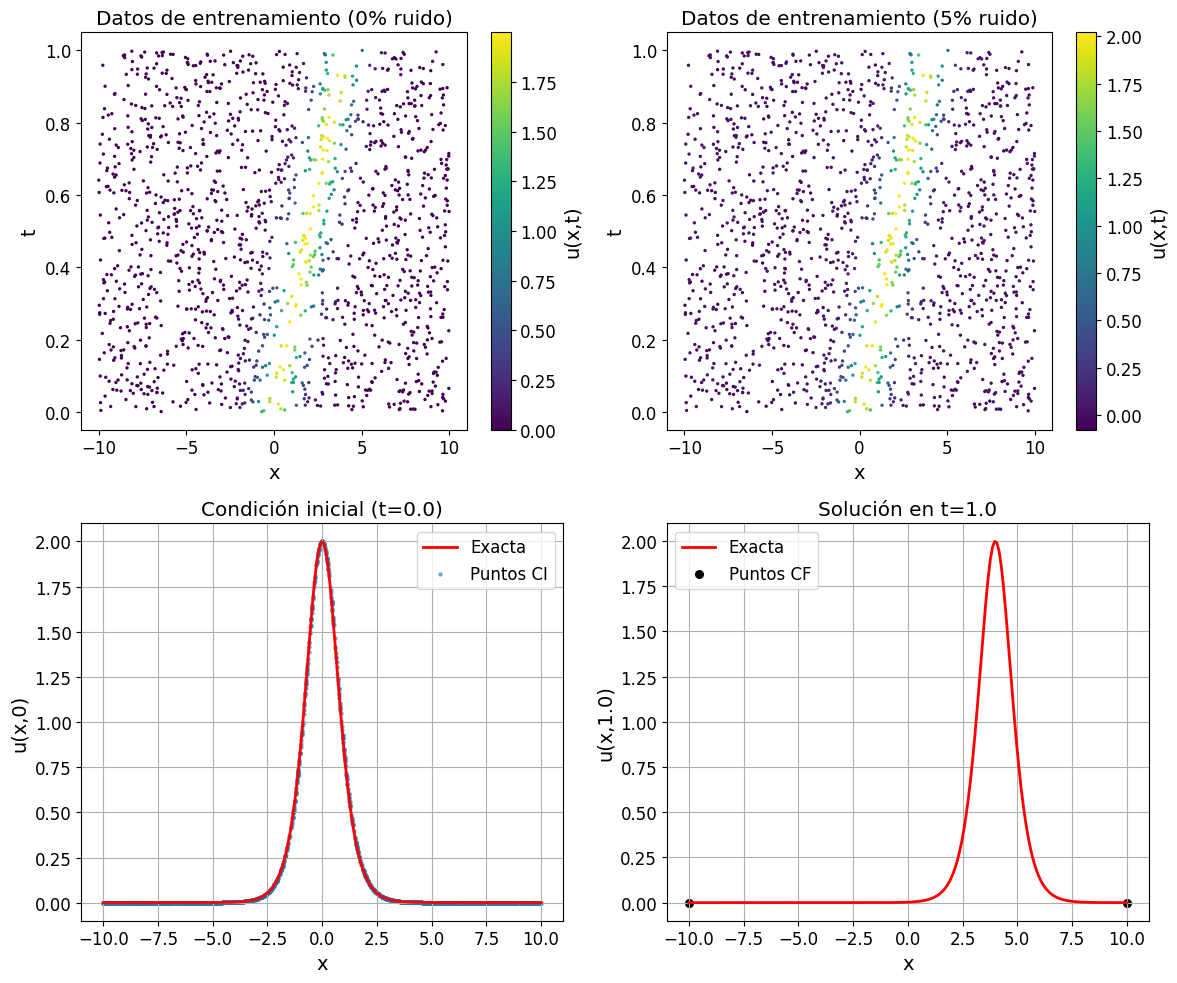

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/20000: Loss = 4.8910e-01, λ1 = 1.0010, λ2 = 0.9990
Epoch 1000/20000: Loss = 9.2924e-02, λ1 = 2.2859, λ2 = 0.0781
Epoch 2000/20000: Loss = 3.6614e-02, λ1 = 3.2427, λ2 = 0.1780
Epoch 3000/20000: Loss = 1.9589e-02, λ1 = 3.8048, λ2 = 0.2941
Epoch 4000/20000: Loss = 1.1213e-02, λ1 = 4.2399, λ2 = 0.4046
Epoch 5000/20000: Loss = 8.7584e-03, λ1 = 4.5972, λ2 = 0.5069
Epoch 6000/20000: Loss = 3.7865e-03, λ1 = 4.8949, λ2 = 0.6000
Epoch 7000/20000: Loss = 2.2837e-03, λ1 = 5.1396, λ2 = 0.6813
Epoch 8000/20000: Loss = 1.2671e-03, λ1 = 5.3363, λ2 = 0.7501
Epoch 9000/20000: Loss = 7.4328e-04, λ1 = 5.4927, λ2 = 0.8065
Epoch 10000/20000: Loss = 4.1692e-04, λ1 = 5.6151, λ2 = 0.8517
Epoch 11000/20000: Loss = 5.7882e-04, λ1 = 5.7100, λ2 = 0.8874
Epoch 12000/20000: Loss = 1.3113e-04, λ1 = 5.7832, λ2 = 0.9153
Epoch 13000/20000: Loss = 7.4955e-05, λ1 = 5.8388, λ2 = 0.9368
Epoch 14000/20000: Loss = 6.5622e-04, λ1 = 5.8811, λ2 = 0.9531
Epoch 15000/20000: Loss = 2.4696e-05, λ1 = 5.9123, λ2 = 0.9654
Epoch

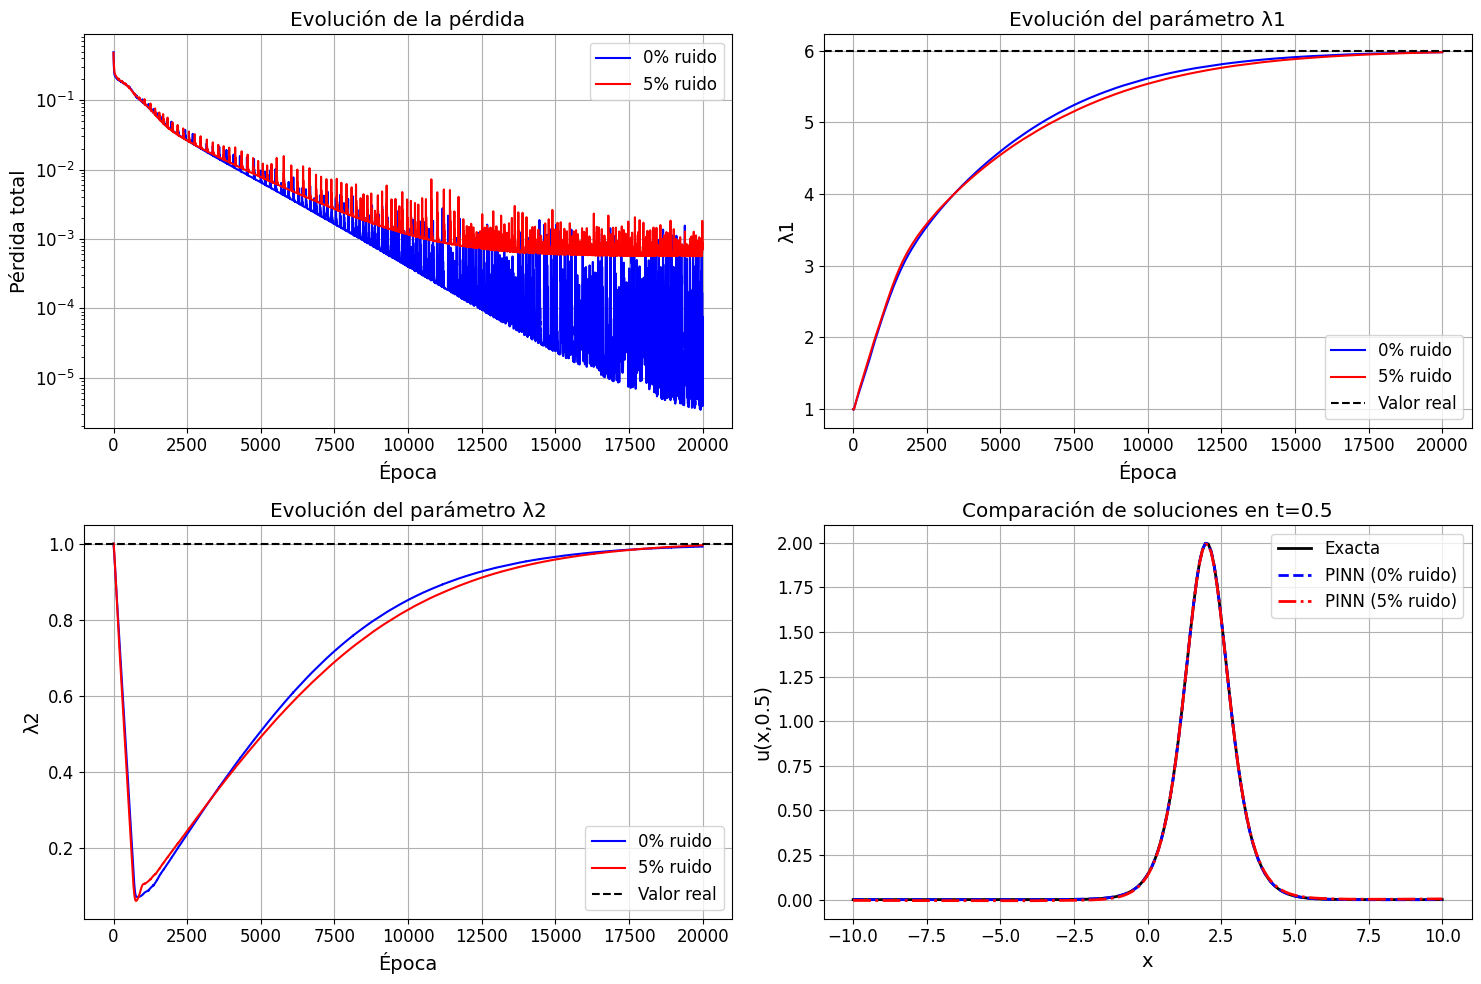


Resultados de identificación de parámetros:
+-------------------------+---------------------------------------+
| Modelo                  | Ecuación Identificada                 |
+=========================+=======================================+
| PDE Correcta            | u_t + 6.000 u u_x + 1.000 u_{xxx} = 0 |
+-------------------------+---------------------------------------+
| Identificado (0% ruido) | u_t + 5.981 u u_x + 0.992 u_xxx = 0   |
+-------------------------+---------------------------------------+
| Identificado (5% ruido) | u_t + 5.981 u u_x + 0.996 u_xxx = 0   |
+-------------------------+---------------------------------------+


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from torch.optim import Adam
from torch.autograd import grad
from tabulate import tabulate

# Configuración general
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 14
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

# ===================== BLOQUE 1: Solución exacta y generación de datos =====================
# Parámetros físicos
lambda1_correcto = 6.0
lambda2_correcto = 1.0
c = 4.0  # velocidad del solitón

# Dominio espacial y temporal
x_min, x_max = -10.0, 10.0
t_min, t_max = 0.0, 1.0

# Solución exacta (solitón KdV)
def u_exacta(x, t, c=c):
    """Solución exacta tipo solitón para la ecuación KdV"""
    return (c/2.0) / np.cosh(np.sqrt(c)/2 * (x - c*t))**2

# Generación de puntos de entrenamiento
Nd = 1500  # Número de puntos de datos
N_i = 2000  # Puntos condición inicial
N_b = 500   # Puntos condición frontera
N_f = 10000 # Puntos para la física (residuales)

# Puntos aleatorios en el dominio
x_data = np.random.uniform(x_min, x_max, Nd)
t_data = np.random.uniform(t_min, t_max, Nd)
u_clean = u_exacta(x_data, t_data)

# Añadir 5% de ruido
ruido = 0.05 * np.std(u_clean) * np.random.randn(Nd)
u_noisy = u_clean + ruido

# Puntos para condiciones iniciales (t=0)
x_ic = np.random.uniform(x_min, x_max, N_i)
t_ic = np.zeros(N_i)
u_ic = u_exacta(x_ic, t_ic)

# Puntos para condiciones de frontera (x=±5)
t_b = np.random.uniform(t_min, t_max, N_b)
x_b = np.concatenate([
    np.full(N_b//2, x_min),
    np.full(N_b - N_b//2, x_max)
])
u_b = np.zeros(N_b)  # Condiciones Dirichlet homogéneas

# Puntos colocation para el residual físico
x_f = np.random.uniform(x_min, x_max, N_f)
t_f = np.random.uniform(t_min, t_max, N_f)

# Convertir a tensores de PyTorch
x_data_t = torch.tensor(x_data, dtype=torch.float32).view(-1, 1).to(device)
t_data_t = torch.tensor(t_data, dtype=torch.float32).view(-1, 1).to(device)
u_clean_t = torch.tensor(u_clean, dtype=torch.float32).view(-1, 1).to(device)
u_noisy_t = torch.tensor(u_noisy, dtype=torch.float32).view(-1, 1).to(device)

x_ic_t = torch.tensor(x_ic, dtype=torch.float32).view(-1, 1).to(device)
t_ic_t = torch.tensor(t_ic, dtype=torch.float32).view(-1, 1).to(device)
u_ic_t = torch.tensor(u_ic, dtype=torch.float32).view(-1, 1).to(device)

x_b_t = torch.tensor(x_b, dtype=torch.float32).view(-1, 1).to(device)
t_b_t = torch.tensor(t_b, dtype=torch.float32).view(-1, 1).to(device)
u_b_t = torch.tensor(u_b, dtype=torch.float32).view(-1, 1).to(device)

x_f_t = torch.tensor(x_f, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
t_f_t = torch.tensor(t_f, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)

# Visualización de los datos
plt.figure(figsize=(12, 10))

# Datos limpios
plt.subplot(221)
plt.scatter(x_data, t_data, c=u_clean, cmap='viridis', s=2)
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Datos de entrenamiento (0% ruido)')

# Datos con ruido
plt.subplot(222)
plt.scatter(x_data, t_data, c=u_noisy, cmap='viridis', s=2)
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Datos de entrenamiento (5% ruido)')

# Perfil en t=0
t_eval = 0.0
x_eval = np.linspace(x_min, x_max, 200)
u_eval = u_exacta(x_eval, t_eval)

plt.subplot(223)
plt.plot(x_eval, u_eval, 'r-', linewidth=2, label='Exacta')
plt.scatter(x_ic, u_ic, s=5, alpha=0.5, label='Puntos CI')
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.title(f'Condición inicial (t={t_eval})')
plt.legend()
plt.grid(True)

# Perfil en t=1
t_eval = 1.0
u_eval = u_exacta(x_eval, t_eval)

plt.subplot(224)
plt.plot(x_eval, u_eval, 'r-', linewidth=2, label='Exacta')
plt.scatter([x_min, x_max], [0, 0], s=30, c='k', label='Puntos CF')
plt.xlabel('x')
plt.ylabel(f'u(x,{t_eval})')
plt.title(f'Solución en t={t_eval}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('kdv_training_data.pdf')
plt.show()

# ===================== BLOQUE 2: Definición y entrenamiento de la PINN =====================
class KdVPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1),
        )

        # Parámetros físicos a identificar (inicializados con valores incorrectos)
        self.lambda1 = nn.Parameter(torch.tensor([1.0], dtype=torch.float32)) #INICIALIZAR MAS CERCA AQUI LANDA1=1 Y LANDA2=0.1
        self.lambda2 = nn.Parameter(torch.tensor([1.0], dtype=torch.float32))

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

    def compute_derivatives(self, x, t):
        """Calcula las derivadas necesarias para la ecuación KdV"""
        u = self(x, t)

        # Calcular derivadas primeras
        u_t = grad(u, t, grad_outputs=torch.ones_like(u),
                  create_graph=True, retain_graph=True)[0]
        u_x = grad(u, x, grad_outputs=torch.ones_like(u),
                  create_graph=True, retain_graph=True)[0]

        # Calcular derivadas de orden superior
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                   create_graph=True, retain_graph=True)[0]
        u_xxx = grad(u_xx, x, grad_outputs=torch.ones_like(u_xx),
                   create_graph=True, retain_graph=True)[0]

        return u, u_t, u_x, u_xxx

def train_model(data_type='clean'):
    """Entrena la PINN para datos limpios o con ruido"""
    # Seleccionar datos
    u_data = u_clean_t if data_type == 'clean' else u_noisy_t

    # Inicializar modelo y optimizador
    model = KdVPINN().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    # Historial de pérdidas
    losses = []
    lambda1_hist = []
    lambda2_hist = []

    epochs = 20000   #Aumentar incide en la aproximacion de los parametros a25K

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Pérdida de datos
        u_pred_data = model(x_data_t, t_data_t)
        loss_data = torch.mean((u_pred_data - u_data)**2)

        # Pérdida de condición inicial
        u_pred_ic = model(x_ic_t, t_ic_t)
        loss_ic = torch.mean((u_pred_ic - u_ic_t)**2)

        # Pérdida de condición de frontera
        u_pred_b = model(x_b_t, t_b_t)
        loss_bc = torch.mean(u_pred_b**2)  # u(±10,t) = 0

        # Pérdida física (PDE residual)
        u_pred, u_t, u_x, u_xxx = model.compute_derivatives(x_f_t, t_f_t)
        residual = u_t + model.lambda1 * u_pred * u_x + model.lambda2 * u_xxx
        loss_physics = torch.mean(residual**2)

        # Pérdida total (todos los pesos = 1)
        loss_total = loss_data + loss_physics + loss_ic + loss_bc

        # Registrar valores
        losses.append(loss_total.item())
        lambda1_hist.append(model.lambda1.item())
        lambda2_hist.append(model.lambda2.item())

        # Retropropagación
        loss_total.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}/{epochs}: Loss = {loss_total.item():.4e}, '
                  f'λ1 = {model.lambda1.item():.4f}, λ2 = {model.lambda2.item():.4f}')

    print(f"\nEntrenamiento finalizado ({data_type} data)")
    print(f"λ1 identificado: {model.lambda1.item():.4f} (valor real: {lambda1_correcto})")
    print(f"λ2 identificado: {model.lambda2.item():.4f} (valor real: {lambda2_correcto})")

    return model, losses, lambda1_hist, lambda2_hist

# Entrenar con datos limpios
model_clean, losses_clean, l1_clean, l2_clean = train_model('clean')

# Entrenar con datos ruidosos
model_noisy, losses_noisy, l1_noisy, l2_noisy = train_model('noisy')

# ===================== Visualización de resultados =====================
# 1. Evolución de los parámetros y pérdidas
plt.figure(figsize=(15, 10))

# Pérdidas
plt.subplot(221)
plt.plot(losses_clean, 'b-', label='0% ruido')
plt.plot(losses_noisy, 'r-', label='5% ruido')
plt.yscale('log')
plt.xlabel('Época')
plt.ylabel('Pérdida total')
plt.legend()
plt.grid(True)
plt.title('Evolución de la pérdida')

# Parámetro λ1
plt.subplot(222)
plt.plot(l1_clean, 'b-', label='0% ruido')
plt.plot(l1_noisy, 'r-', label='5% ruido')
plt.axhline(y=lambda1_correcto, color='k', linestyle='--', label='Valor real')
plt.xlabel('Época')
plt.ylabel('λ1')
plt.legend()
plt.grid(True)
plt.title('Evolución del parámetro λ1')

# Parámetro λ2
plt.subplot(223)
plt.plot(l2_clean, 'b-', label='0% ruido')
plt.plot(l2_noisy, 'r-', label='5% ruido')
plt.axhline(y=lambda2_correcto, color='k', linestyle='--', label='Valor real')
plt.xlabel('Época')
plt.ylabel('λ2')
plt.legend()
plt.grid(True)
plt.title('Evolución del parámetro λ2')

# Comparación de soluciones en t=0.5
t_eval = 0.5
x_eval = torch.linspace(x_min, x_max, 200).view(-1, 1).to(device)
t_eval_tensor = torch.full_like(x_eval, t_eval).to(device)

# Soluciones
u_exact = u_exacta(x_eval.cpu().numpy(), t_eval)
u_pred_clean = model_clean(x_eval, t_eval_tensor).detach().cpu().numpy()
u_pred_noisy = model_noisy(x_eval, t_eval_tensor).detach().cpu().numpy()

plt.subplot(224)
plt.plot(x_eval.cpu(), u_exact, 'k-', linewidth=2, label='Exacta')
plt.plot(x_eval.cpu(), u_pred_clean, 'b--', linewidth=2, label='PINN (0% ruido)')
plt.plot(x_eval.cpu(), u_pred_noisy, 'r-.', linewidth=2, label='PINN (5% ruido)')
plt.xlabel('x')
plt.ylabel(f'u(x,{t_eval})')
plt.legend()
plt.grid(True)
plt.title(f'Comparación de soluciones en t={t_eval}')

plt.tight_layout()
plt.savefig('kdv_results.pdf')
plt.show()

# Tabla de resultados
table = [
    ["PDE Correcta", "u_t + 6.000 u u_x + 1.000 u_{xxx} = 0"],
    ["Identificado (0% ruido)", f"u_t + {model_clean.lambda1.item():.3f} u u_x + {model_clean.lambda2.item():.3f} u_xxx = 0"],
    ["Identificado (5% ruido)", f"u_t + {model_noisy.lambda1.item():.3f} u u_x + {model_noisy.lambda2.item():.3f} u_xxx = 0"]
]

print("\nResultados de identificación de parámetros:")
print(tabulate(table, headers=["Modelo", "Ecuación Identificada"], tablefmt="grid"))